### An Audio Version of MNIST Dataset

In [64]:
import numpy as np
import IPython.display as i_dis
import os
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import tqdm

import tensorflow as tf
import sklearn
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

MAIN_DIR = "/home/deadpool/github/MNIST-AUDIO-CLASSIFICATION/"
DATA_DIR = os.path.join(MAIN_DIR,"mnist spoken data","recordings")
SAMPLE_DIR = os.path.join(MAIN_DIR,"samples")
LABELS = ["ZERO","ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT","NINE"]
LENGTH = 9000
# os.makedirs("Figures",exist_ok=True)
# FIG_DIR = os.path.join(MAIN_DIR,"Figures")
# print(MAIN_DIR)

<Figure size 720x576 with 0 Axes>

In [2]:
os.chdir(DATA_DIR)
print("Play a sample wavfile from the datset:")
i_dis.Audio("0_theo_4.wav")

Play a sample wavfile from the datset:


### Prepare Dataset

In [4]:
def fetch_data(length=LENGTH):
    audio = []
    labels = []
    for file in os.listdir():
        
        a, SR = librosa.load(file,sr=None)
        a, index = librosa.effects.trim(a,top_db=20,frame_length=256, hop_length=64)
        if(len(a)>length or len(a)<2000):
            continue
        elif(len(a)<length):
            a = np.pad(a,(0,length-len(a)),constant_values=(0,0))
        audio.append(a)
        labels.append(file[0])
    return audio,SR,labels

In [5]:
audios, SR, labels = fetch_data(length=4000)

In [6]:
sample_len = [len(x) for x in audios]

In [7]:
print(SR)
print(len(audios))

8000
1228


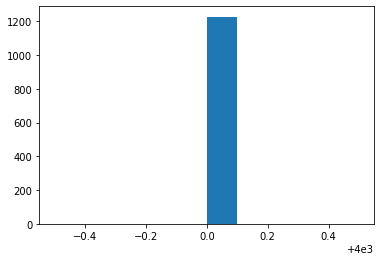

In [8]:
plt.hist(sample_len)
plt.show()

In [9]:
np.percentile(sample_len,91)

4000.0

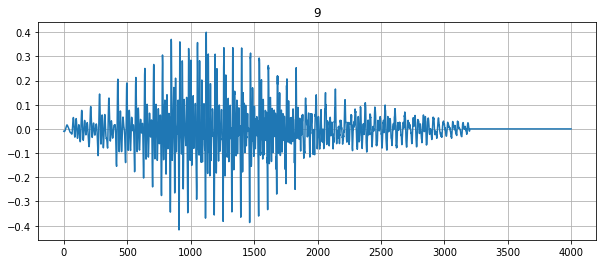

In [10]:
# librosa.display.waveplot(audios[0],sr=SR)
plt.figure(figsize=(10,4))
plt.title(labels[0])
plt.plot(audios[1000])
plt.grid("ON")
plt.show()

In [11]:
mfcc = librosa.feature.mfcc(audios[0],sr=SR,n_mfcc=15,hop_length=125,n_fft=512)

[Text(0.5, 1.0, 'MFCC')]

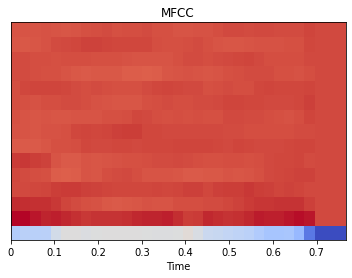

In [12]:
fig, ax = plt.subplots()
img = display.specshow(mfcc, x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [13]:
mfcc.shape

(15, 33)

In [56]:
import pandas as pd

In [57]:
data = pd.Series(labels)

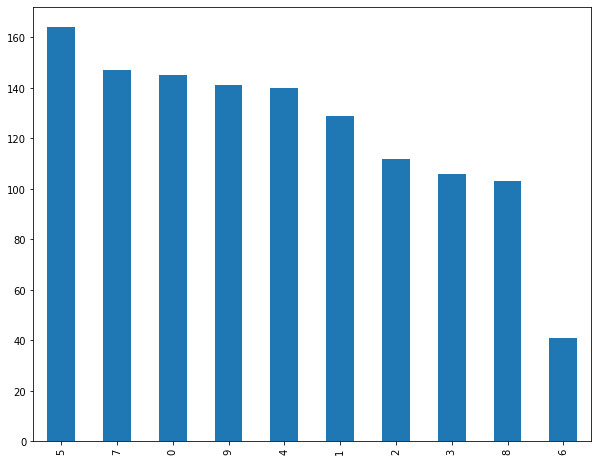

In [65]:
plt.figure(figsize=(10,8))
data.value_counts().plot(kind="bar")
plt.show()

### Data Augmentation

### NOISE ADDITION

In [98]:
def add_noise(data, FACTOR=0.003):
    noise = np.random.randn(len(data))
    new_data = data + FACTOR * noise
    return new_data.astype(type(data[0]))
    

In [99]:
new_audios = list(map(add_noise,audios))

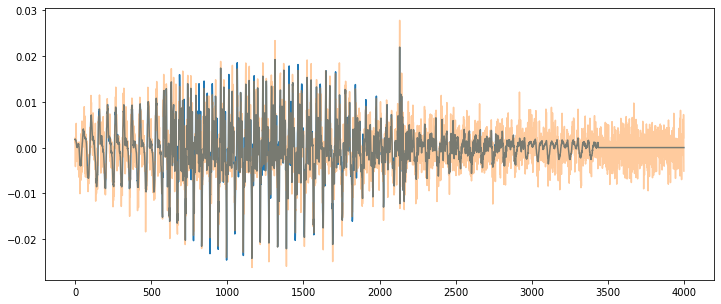

In [101]:
plt.figure(figsize=(12,5))
plt.plot(audios[0])
plt.plot(new_audios[0],alpha=0.4)
plt.show()

### TIME SHIFTING

In [104]:
def time_shift(data,SHIFT_LEN=200,SHIFT_DIR ="RIGHT"):
#     if SHIFT_DIR == "RIGHT":
#         shift = - shift
#     elif 
    shifted_data = np.roll(data,shift)
    return shifted_data

### Extract Features

In [15]:
def extract_MFCC(audio,SR,n_mfcc=20,hop_length=125,n_fft=256):
    features = []
    for a,index in zip(audio,tqdm.tqdm( range(len(audio)),desc="Extracting Features: ")):
        mfcc = librosa.feature.mfcc(a,sr=SR,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft)
        features.append(mfcc.T)
    return features

In [16]:
features = extract_MFCC(audios,SR)

Extracting Features: 100%|█████████▉| 1227/1228 [00:08<00:00, 148.39it/s]


In [17]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels).astype('float64')

In [18]:
X = np.array(features)
Y = encoded_labels

In [19]:
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)

train_id, test_id = next(splitter.split(X,Y))
X_train,y_train,X_test,y_test = X[train_id],Y[train_id],X[test_id],Y[test_id]

train_id, test_id = next(splitter.split(X_train,y_train))
X_train,y_train,X_val,y_val = X_train[train_id],y_train[train_id],X_train[test_id],y_train[test_id]

In [20]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)

In [21]:
print(X_train[0].shape)
print(X_train.shape)
print(X_test.shape)

(33, 20, 1)
(994, 33, 20, 1)
(123, 33, 20, 1)


In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=INPUT_SHAPE,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [23]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 18, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 18, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 9, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 7, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 7, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 3, 32)          4

In [25]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)

In [26]:
history = model.fit(X_train,y_train,epochs=30,batch_size=30,validation_data=(X_val,y_val),callbacks=[earlystop_callback])

Epoch 1/30
34/34 [==============================] - 2s 47ms/step - loss: 1.7963 - accuracy: 0.4487 - val_loss: 2.1153 - val_accuracy: 0.3784
Epoch 2/30
34/34 [==============================] - 1s 38ms/step - loss: 0.7549 - accuracy: 0.8189 - val_loss: 1.1055 - val_accuracy: 0.6216
Epoch 3/30
34/34 [==============================] - 1s 41ms/step - loss: 0.3707 - accuracy: 0.9406 - val_loss: 0.4748 - val_accuracy: 0.8829
Epoch 4/30
34/34 [==============================] - 1s 38ms/step - loss: 0.2339 - accuracy: 0.9718 - val_loss: 0.3906 - val_accuracy: 0.9279
Epoch 5/30
34/34 [==============================] - 1s 38ms/step - loss: 0.2005 - accuracy: 0.9759 - val_loss: 0.3122 - val_accuracy: 0.9279
Epoch 6/30
34/34 [==============================] - 1s 43ms/step - loss: 0.1904 - accuracy: 0.9738 - val_loss: 0.2819 - val_accuracy: 0.9189
Epoch 7/30
34/34 [==============================] - 1s 41ms/step - loss: 0.1262 - accuracy: 0.9940 - val_loss: 0.2574 - val_accuracy: 0.9279
Epoch 8/30
34

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

4/4 [==============================] - 0s 11ms/step - loss: 0.1261 - accuracy: 0.9837

Test loss: 0.12612292170524597, test accuracy: 98.37398529052734


In [28]:
os.chdir(SAMPLE_DIR)

In [29]:
i_dis.Audio("0_rabin_0.wav")

In [30]:
sample,gan = librosa.load("0_rabin_0.wav",sr=None)

In [31]:
len(sample)

11762

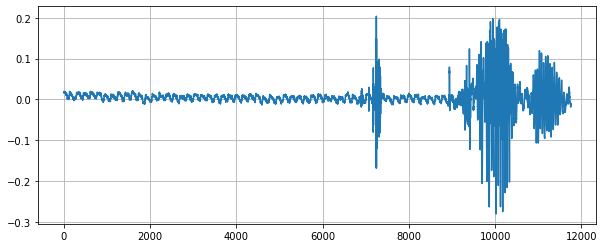

In [32]:
plt.figure(figsize=(10,4))
plt.plot(sample)
plt.grid("ON")
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
off = int(len(sample)/2)
# sample =sample[:4000]
plt.plot(trimmed[:4000])
plt.grid("ON")
plt.show()

In [ ]:
trimmed, index = librosa.effects.trim(sample,top_db=10,frame_length=256, hop_length=64)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(trimmed)
plt.grid("ON")
plt.show()

In [ ]:
len(trimmed)

In [ ]:
index

In [ ]:
mfcc = librosa.feature.mfcc(sample[:4000],sr=gan,n_mfcc=13,hop_length=256,n_fft=2048)

In [ ]:
mfcc.shape

In [ ]:
mfcc = mfcc[...,np.newaxis]

In [ ]:
mfcc = mfcc[np.newaxis,...]

In [ ]:
mfcc.shape

In [ ]:
model.predict_classes(mfcc)

In [55]:
real_data = []
real_labels = []
LENGTH = 4000
THRESHOLD = 2000

for file in os.listdir():
    sample,sr = librosa.load(file,sr=None)
    sample, index = librosa.effects.trim(sample,top_db=15,frame_length=256, hop_length=64)
    if(len(sample)>LENGTH):
        sample = sample[:LENGTH]
    if(len(sample)<THRESHOLD):
        print("Corrupt file")
        continue
    if(len(sample)<LENGTH):
        sample = np.pad(sample,(0,LENGTH-len(sample)),constant_values=(0,0))
    mfcc = librosa.feature.mfcc(sample,sr=sr,n_mfcc=20,hop_length=125,n_fft=256)
    real_data.append(mfcc.T)
    real_labels.append(float(file[0]))
    mfcc = mfcc.T[np.newaxis,...,np.newaxis]
    p = model.predict_classes(mfcc)
    print(int(p), end="   ")
    print(file[0])

print(len(real_data))
print(type(real_data))

real_data =np.array(real_data)
real_labels = np.array(real_labels)
real_data = real_data[...,np.newaxis]
model.evaluate(real_data,real_labels)

3   0
7   9
3   6
7   7
Corrupt file
3   3
7   7
7   0
1   1
Corrupt file
3   3
Corrupt file
3   6
3   8
Corrupt file
7   5
3   5
9   9
1   1
3   5
Corrupt file
Corrupt file
3   6
3   9
9   0
7   7
Corrupt file
9   4
3   3
1   1
23
<class 'list'>
1/1 [==============================] - 0s 1ms/step - loss: 2.6029 - accuracy: 0.4348


[2.6029393672943115, 0.43478259444236755]

In [40]:
os.listdir()

['2_theo_37.wav',
 '0_jackson_25.wav',
 '1_yweweler_5.wav',
 '2_theo_38.wav',
 '0_nicolas_26.wav',
 '2_theo_36.wav',
 '1_nicolas_30.wav',
 '0_nicolas_25.wav',
 '1_yweweler_8.wav',
 '0_jackson_26.wav',
 '0_jackson_27.wav',
 '1_yweweler_6.wav',
 '1_nicolas_31.wav',
 '1_yweweler_7.wav',
 '0_jackson_28.wav']

In [42]:
print(real_labels)

[2. 0. 1. 2. 0. 2. 1. 0. 1. 0. 0. 1. 1. 1. 0.]


In [43]:
model.predict_classes(real_data)

array([2, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 5, 0])

In [48]:
model.predict_classes(real_data[0][np.newaxis,...])

array([2])

In [47]:
real_data[0].shape

(33, 20, 1)